# Set Root

In [1]:
import os
import re

root_path = re.findall('.*?predict_bad_rate', os.getcwd())[0]
os.chdir(root_path)

# Leer YAML

In [2]:
import yaml

with open('params.yaml', 'r') as file:
    yaml_config = yaml.safe_load(file)

# Importación de Bibliotecas

In [3]:
import numpy as np
import sklearn.metrics as skm
import plotly.express as px
import plotly.graph_objects as go
import joblib as jl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Carga de Datos de Piloto

<font style='color:red; font-weight:bold'>ALERTA!!!</font> la sección 'Carga del Parquet' contiene la versiones de estos archivos en parquet para hacer la carga más rápida.

In [4]:
datos_buro = pd.read_excel(
    yaml_config['centralizado']['folder_raw_piloto'] +
    'Informes comerciales por ID - Calificación centralizada Junio-30.xlsx'
)

datos_buro.columns = datos_buro.columns.str.lower()
datos_buro['peor_sit_bureau_ult'] = (
    datos_buro['peor_sit_bureau_ult']
    .astype(str)
)
datos_buro.set_index('id', inplace=True)

datos_personales = pd.read_excel(
    yaml_config['centralizado']['folder_raw_piloto'] +
    'Datos Personales por ID - Calificación centralizada Junio-30.xlsx',
)

datos_personales.columns = datos_personales.columns.str.lower()

datos_externos = pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] +
    'data_piloto_with_external_variables_20220801.parquet',
).set_index('id_cliente')
datos_externos.drop(columns=['calle',
                             'cd_postal',
                             'ciudad',
                             'provincia',
                             'pais',
                             'address',
                             'latitude',
                             'longitude',
                             'score',
                             'country',
                             'success',
                             'message',
                             'h3_id'], inplace=True)


In [5]:
datos_buro.index.nunique(), datos_buro.shape

(57986, (57986, 59))

In [6]:
datos_buro[datos_buro.riesgo_score>350].shape

(50632, 59)

In [7]:
datos_buro['cartera'].value_counts()

'2'    57986
Name: cartera, dtype: int64

In [5]:
datos_buro['cartera']=datos_buro['cartera'].replace('\'', '', regex=True)
datos_buro['cartera']= pd.to_numeric(
    datos_buro['cartera'], errors='coerce'
)

In [6]:
_client_rules=datos_buro.index[datos_buro.riesgo_score>350]

In [7]:
datos_personales['id cliente'].nunique(), datos_personales.shape

(57987, (57987, 10))

In [8]:
datos_personales_rules_350 = datos_personales[
    datos_personales['id cliente']
    .isin(_client_rules)]

In [9]:
datos_personales_rules_350.shape

(50632, 10)

In [13]:
datos_personales_rules_350['calle']=datos_personales_rules_350['calle'].astype(str)
datos_personales_rules_350['cd postal']=datos_personales_rules_350['cd postal'].astype(str)

/tmp/ipykernel_11036/3192857139.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_personales_rules_350['calle']=datos_personales_rules_350['calle'].astype(str)
/tmp/ipykernel_11036/3192857139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_personales_rules_350['cd postal']=datos_personales_rules_350['cd postal'].astype(str)


In [73]:
datos_personales_rules_350.drop(
    columns=['sexo','fecha nacimiento dt','estado civil']
).to_parquet(
    yaml_config['centralizado']['folder_processed'] +
    'data_to_geo_centralizado_piloto20220801.parquet'
)

In [14]:
datos_buro_rules_350 = datos_buro[datos_buro.riesgo_score>350]

# Guarda datos para cargarlos más rápido

In [75]:
datos_buro_rules_350.to_parquet(
    yaml_config['centralizado']['folder_processed'] +
    'variables_buro_piloto_rules_350_20220801.parquet'
)

# Carga del Parquet

In [15]:
datos_buro_rules_350 = pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] +
    'variables_buro_piloto_rules_350_20220801.parquet'
)

# Merge con datos externos

In [16]:
X_piloto = datos_buro_rules_350.join(datos_externos)

# Fill de variables ordinales

Hay que hacer el ajuste de colocar un imputer sobre la variable ordinal, o dejarla como con el valor más grande (o más pequeño según la categorización)

In [17]:
X_piloto.ip.fillna(
    X_piloto.ip.mode().item(),
    inplace=True
)

# Predicción

## Carga de Modelo

In [18]:
pipeline = jl.load(yaml_config['centralizado']['modelo'])
preds = pipeline.predict_proba(X_piloto)[:, 1]
thr=yaml_config['centralizado']['trh_model']

In [19]:
preds = pd.DataFrame(
    {"id_cliente":X_piloto.index,
     "riesgo_score":X_piloto.riesgo_score,
     "score":preds
    })
preds["aprobado"]=np.where(preds.score<thr,"SI","NO")

In [20]:
preds["aprobado"].value_counts(normalize=True)

NO    0.506952
SI    0.493048
Name: aprobado, dtype: float64

# Preds Train

In [21]:
X_train=pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] + 
    'train_buro_centralizado_whit_external_without_score_less_350.parquet'
)

In [22]:
preds_train = pipeline.predict_proba(X_train)[:, 1]
preds_train = pd.DataFrame(
    {"id_cliente":X_train.index,
     "riesgo_score":X_train.riesgo_score,
     "score":preds_train
    })
preds_train["aprobado"]=np.where(preds_train.score<thr,"SI","NO")

In [23]:
preds_train.aprobado.value_counts(normalize=True)

SI    0.671243
NO    0.328757
Name: aprobado, dtype: float64

# Valida PSI

In [24]:
EPSILON = 1e-6

def population_stability_index(
    expected_scores: np.ndarray,
    actual_scores: np.ndarray,
    num_deciles: int = 10,
    return_df: bool = False,
):
    """
    Calculates the PSI (Population Stability Index).

    Arguments:
        expected_scores: np.ndarray. Scores of reference, i.e., the
                    training scores used to calibrate the model.
        actual_scores: np.ndarray. Scores produced by the model
                                   on an inference dataset.
        num_deciles: int, the number of buckets to calculate
                          the differences with.
        return_df: bool, whether to return a DataFrame with the details
                         of the calculation.

    Returns:
        psi: float. The PSI value.
            There are 3 cases to take into account in order
            to interpret this value:

            PSI < 0.1 - No change. You can continue
                           using existing model.

            PSI >= 0.1 but less than 0.2 - Slight change is required.

            PSI >= 0.2 - Significant change is required.
            Ideally, you should not use this model any more.
        Optionally, also returns:
            df: pd.DataFrame, a table showing the details of
                the calculation
    """
    deciles = (np.arange(0, num_deciles + 1) / num_deciles) * 100

    bins = np.percentile(expected_scores, deciles)

    expected_percent = np.histogram(expected_scores, bins=bins)[0] / len(
        expected_scores
    )

    actual_percent = np.histogram(actual_scores, bins=bins)[0] / len(actual_scores)

    diff = actual_percent - expected_percent

    ln = np.log((actual_percent + EPSILON) / (expected_percent + EPSILON))
    psi = np.sum(diff * ln)

    if return_df:
        df = pd.DataFrame(
            data={
                "decile": (deciles[1:] // 10).astype(int),
                "bin": bins[1:],
                "actual % (A)": actual_percent,
                "expected % (E)": expected_percent,
                "A-E": diff,
                "ln(A/E)": ln,
                "PSI": diff * ln,
            }
        )
        return psi, df

    return psi

In [25]:
population_stability_index(preds_train.score, preds.score)

0.24373853222859285

/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'riesgo_score')

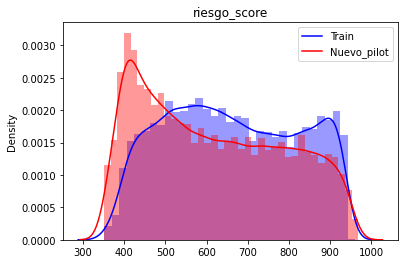

In [26]:
sns.distplot(X_train['riesgo_score'], color='b')
sns.distplot(X_piloto['riesgo_score'], color='r')
plt.legend(labels=["Train", "Nuevo_pilot"])
plt.xlabel("")
plt.title('riesgo_score')

/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'riesgo_score en aprobados')

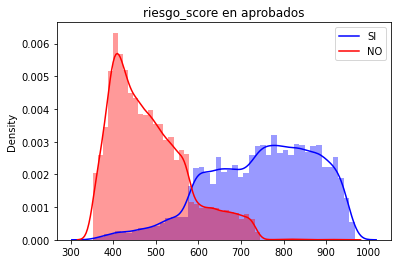

In [27]:
sns.distplot(preds['riesgo_score'][preds.aprobado=="SI"], color='b')
sns.distplot(preds['riesgo_score'][preds.aprobado=="NO"], color='r')
plt.legend(labels=["SI", "NO"])
plt.xlabel("")
plt.title('riesgo_score en aprobados')

In [ ]:
## validar cambio de distribucion de las variables

In [28]:
from scipy import stats

In [29]:
len(list(X_train.drop(columns=['fecha']).columns))

262

In [30]:
ks_pvalues = pd.DataFrame(X_train.drop(columns=['fecha','fecha_alta_sistema','ip']).columns,columns=['variables'])

In [31]:
# Evaluando las distribuciones de X_Train, X_val, X_test

ks_train_piloto = []

ks_train_piloto_pvalue = []

for col in list(X_train.drop(columns=['fecha', 'fecha_alta_sistema', 'ip']).columns): 
    try:
        ks_train_piloto.append(stats.ks_2samp(X_train[col], X_piloto[col])[0])

        ks_train_piloto_pvalue.append(stats.ks_2samp(X_train[col], X_piloto[col])[1])
    except:
        print(col)

In [32]:
ks_pvalues.loc[:,'ks_train_piloto'] = ks_train_piloto

ks_pvalues.loc[:,'ks_train_piloto_pvalue'] = ks_train_piloto_pvalue

ks_pvalues.loc[:,'train_piloto_eq'] = np.where(ks_pvalues['ks_train_piloto_pvalue']<0.1,0,1)

In [151]:
ks_pvalues.to_excel(
    yaml_config['centralizado']['folder_processed'] +
    'KS_Train_piloto20220801.xlsx')

# Escogencia de clientes por distancia de gower

In [10]:
base_d50_noselecc=pd.read_parquet(
    yaml_config['centralizado']['folder_processed'] + 
    'clientes_distantes_piloto_centralizado_20220801.parquet'
)

In [41]:
base_d50_noselecc.d50.min(),base_d50_noselecc.d50.max()

(0.011761584, 0.2679589)

In [34]:
preds2=preds[~preds.id_cliente.isin(base_d50_noselecc.id_aprob)]

In [35]:
preds2.aprobado.value_counts(normalize=True)

SI    0.582274
NO    0.417726
Name: aprobado, dtype: float64

In [36]:
population_stability_index(preds_train.score, preds2.score)

0.10535741979083728

/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'riesgo_score')

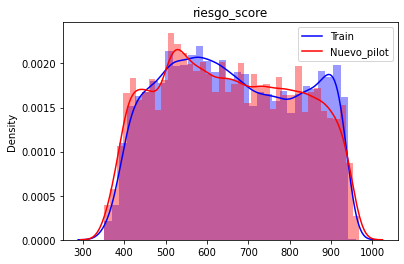

In [37]:
sns.distplot(preds_train['riesgo_score'], color='b')
sns.distplot(preds2['riesgo_score'], color='r')
plt.legend(labels=["Train", "Nuevo_pilot"])
plt.xlabel("")
plt.title('riesgo_score')

/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/danielosorio/.cache/pypoetry/virtualenvs/bna-ar-IixNjU1e-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'riesgo_score en aprobados')

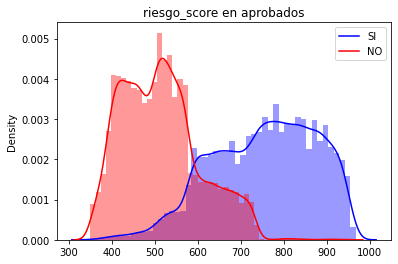

In [38]:
sns.distplot(preds2['riesgo_score'][preds2.aprobado=="SI"], color='b')
sns.distplot(preds2['riesgo_score'][preds2.aprobado=="NO"], color='r')
plt.legend(labels=["SI", "NO"])
plt.xlabel("")
plt.title('riesgo_score en aprobados')

## Exportación

In [46]:
preds2.drop(columns=['riesgo_score']).sort_values('score').to_excel(
    yaml_config['centralizado']['folder_final'] +
    'predicciones_piloto_20220801.xlsx',
    index=False
)